# EMRI Waveforms in Fourier Domain
Here we present the usage of the EMRI Waveforms in Fourier Domain. Currently we implemented the Fourier Domain Waveform only for the Schawrzchild case.

In [1]:
import sys, time, h5py,os

import matplotlib
import scienceplots
import numpy as np
import matplotlib.pyplot as plt

# import or install these packages for the data anlysis of the resultss
sys.path.append("../LISAanalysistools/")
sys.path.append("../Eryn/")

import corner
from lisatools.sampling.likelihood import Likelihood
from lisatools.diagnostic import *
from lisatools.sensitivity import get_sensitivity

from few.waveform import GenerateEMRIWaveform
from few.utils.utility import get_mu_at_t
from few.utils.constants import *
from few.utils.utility import *
from few.trajectory.inspiral import EMRIInspiral
traj_module = EMRIInspiral(func="SchwarzEccFlux")
omp_set_num_threads(1)
from few.utils.utility import cuda_set_device

from scipy.signal.windows import tukey, hann, boxcar, nuttall, blackman
from FDutils import *

try:
    import cupy as xp
    # set GPU device
    os.system(f"CUDA_VISIBLE_DEVICES=0")
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    use_gpu = True

except (ImportError, ModuleNotFoundError) as e:
    import numpy as xp
    use_gpu = False

import warnings
warnings.filterwarnings("ignore")


few_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True, output_type="fd",odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

td_gen = GenerateEMRIWaveform(
    "FastSchwarzschildEccentricFlux", 
    sum_kwargs=dict(pad_output=True,odd_len=True),
    use_gpu=use_gpu,
    return_list=True
)

# Automated windowing procedure following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))

    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2 * n)
    acf = np.fft.ifft(f * np.conjugate(f))[: len(x)].real
    acf /= 4 * n

    # Optionally normalize
    if norm:
        acf /= acf[0]

    return acf

def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0 * np.cumsum(f) - 1.0
    window = auto_window(taus, c)
    return taus[window]

default_width = 5.78853 # in inches
default_ratio = (np.sqrt(5.0) - 1.0) / 2.0 # golden mean
figsize_std=(default_width,default_width * default_ratio)

def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    if m!='1':
        return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))
    else:
        return r'10^{{{e:d}}}'.format(e=int(e))


def get_colorplot(data, color_value, label, label_cbar):
    colors = color_value
    n_dimensions = data.shape[-1]
    # Plot the corner plot
    figure, axes = plt.subplots(n_dimensions-1, n_dimensions-1, figsize=(10, 10))

    # Custom color map
    cmap = plt.cm.get_cmap('seismic')  # Choose a color map of your preference

    for i in range(n_dimensions-1):
        for j in range(n_dimensions-1):
            if j < i:
                axes[j, i].axis('off')
            else:
                axes[j, i].scatter(data[:, i], data[:, j+1], c=colors, cmap=cmap, s=5,alpha=0.6)
                

    [axes[n_dimensions-2, i].set_xlabel(label[i]) for i in range(n_dimensions-1)]
    [axes[n_dimensions-2, i].set_yticklabels([]) for i in range(1,n_dimensions-1)]
    [axes[j, 0].set_ylabel(label[j+1]) for j in range(n_dimensions-1)]
    [axes[j, 0].set_xticklabels([]) for j in range(n_dimensions-2)]

    # Customize color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=np.min(colors), vmax=np.max(colors)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), anchor=(0.0,11.0), orientation='horizontal')
    cbar.set_label(label_cbar, rotation=0, labelpad=15)

    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    plt.show()



In [2]:
# define the injection parameters
M = 1e6 # central object mass
a = 0.1  # will be ignored in Schwarzschild waveform
mu = 10.0 # secondary object mass
p0 = 12.0 # initial semi-latus rectum
e0 = 0.6 # eccentricity

# M,mu,p0,e0 = 9992906.141310893, 11.305529838590854, 7.060600096664631, 0.19801820863315006

x0 = 1.0  # will be ignored in Schwarzschild waveform
qK = np.pi/3  # polar spin angle
phiK = np.pi/3  # azimuthal viewing angle
qS = np.pi/3  # polar sky angle
phiS = np.pi/3  # azimuthal viewing angle
dist = 1.0  # distance
# initial phases
Phi_phi0 = np.pi/3
Phi_theta0 = 0.0
Phi_r0 = np.pi/3

Tobs = 1.0 # observation time, if the inspiral is shorter, the it will be zero padded 
dt = 10.0 # time interval
eps = 1e-2 # mode content percentage
mode_selection = [(2,2,0)]

waveform_kwargs = {
    "T": Tobs,
    "dt": dt,
# you can uncomment the following ling if you want to show a mode
#     "mode_selection" : mode_selection,
#     "include_minus_m": True
    "eps": eps,
    
}

# get the initial p0 
p0 = get_p_at_t(
traj_module,
Tobs*0.99,
[M, mu, 0.0, e0, 1.0],
index_of_p=3,
index_of_a=2,
index_of_e=4,
index_of_x=5,
traj_kwargs={},
xtol=2e-12,
rtol=8.881784197001252e-16,
bounds=None,
)


emri_injection_params = [
                            M,  
                            mu,
                            a, 
                            p0, 
                            e0, 
                            x0,
                            dist, 
                            qS,
                            phiS,
                            qK, 
                            phiK, 
                            Phi_phi0, 
                            Phi_theta0, 
                            Phi_r0
                        ]

In [3]:
p0

9.561314219034166

## Comparison against the Time Domain Waveforms

In [124]:
# create TD signal
data_channels_td = td_gen(*emri_injection_params, **waveform_kwargs)

# take the FFT of the plus polarization and shift it
fft_TD = xp.fft.fftshift(xp.fft.fft(data_channels_td[0])) * dt
freq = xp.fft.fftshift(xp.fft.fftfreq(len(data_channels_td[0]) , dt))

# define the positive frequencies
positive_frequency_mask = (freq>=0.0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


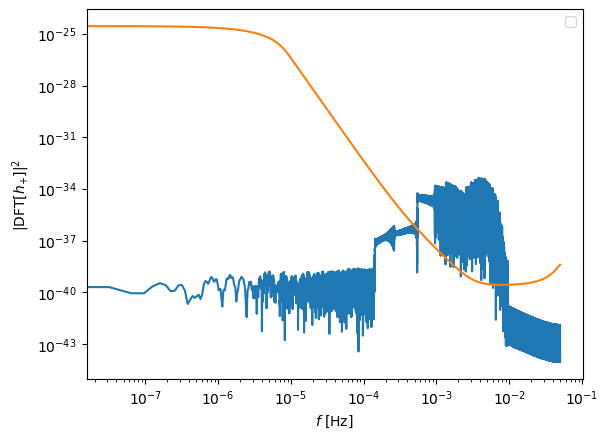

In [125]:
plt.figure()
if use_gpu:
    plt.loglog(freq[positive_frequency_mask].get(), get_sensitivity(freq[positive_frequency_mask].get()))
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(fft_TD[positive_frequency_mask].get())**2)
else:
    plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2)
    plt.loglog(freq[positive_frequency_mask], get_sensitivity(freq[positive_frequency_mask]))
plt.ylabel(r'$| {\rm DFT} [h_{+}]|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
plt.show()

In [126]:
# you can specify the frequencies or obtain them directly from the waveform
fd_kwargs = waveform_kwargs.copy()
fd_kwargs['f_arr'] = freq
fd_kwargs['mask_positive']=True

hf = few_gen(*emri_injection_params,**fd_kwargs)
# to get the frequencies:
freq_fd = few_gen.waveform_generator.create_waveform.frequency

# mismatch
fd_inner_product_kwargs = dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=freq[positive_frequency_mask])
Mism = np.abs(1-inner_product(fft_TD[positive_frequency_mask], hf[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)

mismatch 0.0008526030054986089


In [127]:
# 220 mode
fd_kwargs2 = fd_kwargs.copy()
del fd_kwargs2['eps']
fd_kwargs2['mode_selection'] = [(2,2,0)]
hf_220 = few_gen(*emri_injection_params,**fd_kwargs2)
# sig_fd_windowed = [el[positive_frequency_mask] for el in get_fd_windowed(hf_toconv, window)]

Mism = np.abs(1-inner_product(fft_TD[positive_frequency_mask], hf_220[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)

mismatch 0.9309238577469674


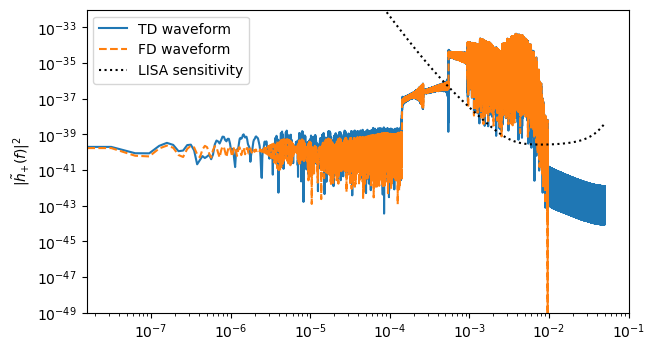

In [128]:
# FD plot
enlarge = 1.1
plt.figure(figsize=(figsize_std[0]*enlarge*1.1,figsize_std[1]*enlarge))
if use_gpu:
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(fft_TD[positive_frequency_mask].get())**2,label='TD waveform')
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(hf[0].get())**2,'--',label='FD waveform')
#     plt.loglog(freq[positive_frequency_mask].get(), np.abs(hf_220[0].get())**2 ,'-.',label='FD waveform (l,m,n)=(2,2,0)',)
    plt.loglog(freq[positive_frequency_mask].get(), get_sensitivity(freq[positive_frequency_mask].get()),'k:',label='LISA sensitivity')

else:
    plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[positive_frequency_mask])**2,label='TD waveform')
    plt.loglog(freq[positive_frequency_mask], np.abs(hf[0])**2,'--',label='FD waveform')
#     plt.loglog(freq[positive_frequency_mask], np.abs(hf_220[0])**2 ,'-.',label='FD waveform (l,m,n)=(2,2,0)',)
    plt.loglog(freq[positive_frequency_mask], get_sensitivity(freq[positive_frequency_mask]),'k:',label='LISA sensitivity')
plt.ylabel(r'$| \tilde{h}_{+} (f)|^2$')
# plt.xlabel(r'$f$ [Hz]')
plt.legend()
plt.ylim([1e-49, 1e-32])

plt.savefig('figures/FD_TD_frequency.pdf', bbox_inches='tight')

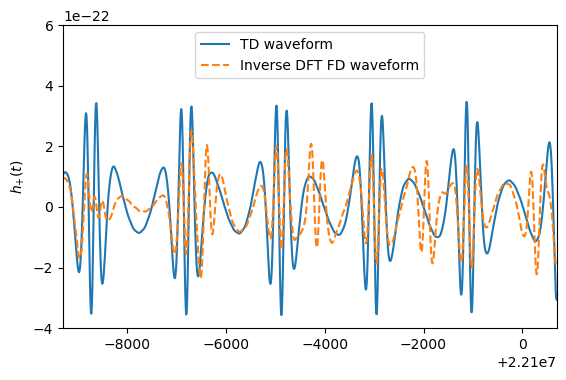

In [129]:
# TD plot
time_array = np.arange(0,len(data_channels_td[0]))*dt
ifft_fd = xp.fft.ifft(xp.append(hf[0],hf[0][::-1][:-1] )/dt)
ifft_fd_22 = xp.fft.ifft(xp.append(hf_220[0],xp.flip(hf_220[0][1:] ))/dt)


enlarge = 1.1
plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))


if use_gpu:
    plt.plot(time_array, data_channels_td[0].get(),label='TD waveform')
    plt.plot(time_array, ifft_fd.get(),'--' ,label='FD waveform')
#     plt.plot(time_array, ifft_fd_22.get(),'-.' ,label='Inverse DFT FD waveform (l,m,n)=(2,2,0)')

else:
    plt.plot(time_array, data_channels_td[0],label='TD waveform')
    plt.plot(time_array, ifft_fd,'--' ,label='Inverse DFT FD waveform')
#     plt.plot(time_array, ifft_fd_22,'-.' ,label='Inverse DFT FD waveform (l,m,n)=(2,2,0)')
plt.ylabel(r'$h_{+}(t)$')
# plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.7
space_t = 10e3
plt.xlim([t0,t0+space_t])
plt.ylim([-4e-22, 6e-22])
plt.legend(loc='upper center')

plt.savefig('figures/FD_TD_time.pdf', bbox_inches='tight')

## Windowing

In [130]:
window = None # xp.asarray(hann(len(data_channels_td[0])))
fft_td_gen = get_fd_waveform_fromTD(td_gen, positive_frequency_mask, dt, window=window)
fd_gen = get_fd_waveform_fromFD(few_gen, positive_frequency_mask, dt, window=window)
fd_kwargs_nomask = fd_kwargs.copy()
del fd_kwargs_nomask['mask_positive']
xp.all(fd_gen(*emri_injection_params,**fd_kwargs_nomask)[0]==hf[0])
# add windowing
window = xp.asarray(hann(len(data_channels_td[0])))#xp.asarray(data_channels_td[0]==0.0,dtype=float)#
fft_td_gen = get_fd_waveform_fromTD(td_gen, positive_frequency_mask, dt, window=window)
fd_gen = get_fd_waveform_fromFD(few_gen, positive_frequency_mask, dt, window=window)

hf = fd_gen(*emri_injection_params,**fd_kwargs_nomask)
fft_TD = fft_td_gen(*emri_injection_params,**fd_kwargs_nomask)

fd_inner_product_kwargs = dict( PSD="cornish_lisa_psd", use_gpu=use_gpu, f_arr=freq[positive_frequency_mask])
Mism = np.abs(1-inner_product(fft_TD[0], hf[0], normalize=True, **fd_inner_product_kwargs))
print("mismatch", Mism)

mismatch 3.909195435247703e-06


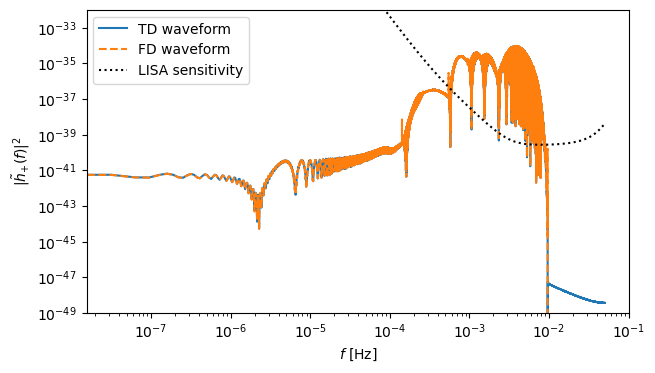

In [131]:
# FD plot
enlarge = 1.1
plt.figure(figsize=(figsize_std[0]*enlarge*1.1,figsize_std[1]*enlarge))
if use_gpu:
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(fft_TD[0].get())**2,label='TD waveform')
    plt.loglog(freq[positive_frequency_mask].get(), np.abs(hf[0].get())**2,'--',label='FD waveform')
    plt.loglog(freq[positive_frequency_mask].get(), get_sensitivity(freq[positive_frequency_mask].get()),'k:',label='LISA sensitivity')

else:
    plt.loglog(freq[positive_frequency_mask], np.abs(fft_TD[0])**2,label='TD waveform')
    plt.loglog(freq[positive_frequency_mask], np.abs(hf[0])**2,'--',label='FD waveform')
    plt.loglog(freq[positive_frequency_mask], get_sensitivity(freq[positive_frequency_mask]),'k:',label='LISA sensitivity')
plt.ylabel(r'$| \tilde{h}_{+}(f)|^2$')
plt.xlabel(r'$f$ [Hz]')
plt.legend()
plt.ylim([1e-49, 1e-32])
plt.savefig('figures/FD_TD_frequency_windowed.pdf', bbox_inches='tight')

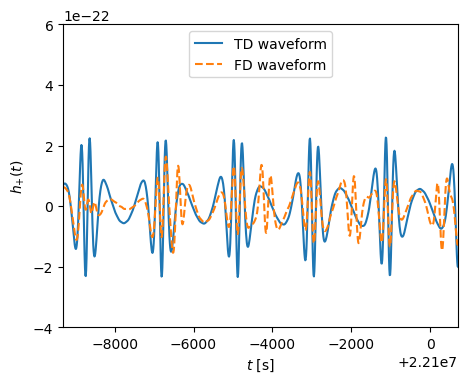

In [132]:
# TD plot
time_array = np.arange(0,len(data_channels_td[0]))*dt
ifft_fd = xp.fft.ifft(xp.append(hf[0],hf[0][::-1][:-1] )/dt)


enlarge = 1.1
plt.figure(figsize=(figsize_std[0]*enlarge*0.8,figsize_std[1]*enlarge))


if use_gpu:
    plt.plot(time_array, data_channels_td[0].get()*window,label='TD waveform')
    plt.plot(time_array, ifft_fd.get(),'--' ,label='FD waveform')

else:
    plt.plot(time_array, data_channels_td[0]*window,label='TD waveform')
    plt.plot(time_array, ifft_fd,'--' ,label='FD waveform')
plt.ylabel(r'$h_{+}(t)$')
plt.xlabel(r'$t$ [s]')

t0 = time_array[-1]*0.7
space_t = 10e3
plt.xlim([t0,t0+space_t])
plt.ylim([-4e-22, 6e-22])
plt.legend(loc='upper center')

plt.savefig('figures/FD_TD_time_windowed.pdf', bbox_inches='tight')

## Mass invariance

In [133]:
list_h = []
list_f = []
T = 4.0
dt = 10.0
Mvec = 10**np.linspace(5.0,6.5,num=3)

for M in Mvec:

    # fix mass ratio
    mu = 5e-5*M

    # rescale time
    Tnew = T*(M/1e6)
    
    # generate wave
    list_h.append(
        few_gen(M,mu,a,p0,e0,x0,dist,qS,phiS,qK,phiK,Phi_phi0,Phi_theta0,Phi_r0,
                T=10.0,dt=dt,mode_selection=[(2,2,0)],mask_positive=True)
    )

    # adimensionless frequency
    list_f.append(few_gen.waveform_generator.create_waveform.frequency * M * MTSUN_SI )
    

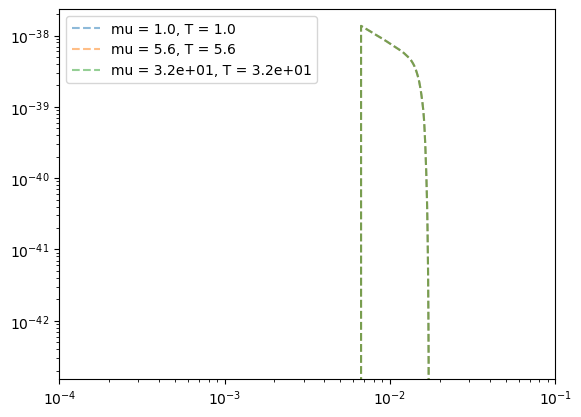

In [134]:
plt.figure()

for ii in range(len(Mvec)):
    Tnew = 10.0 * Mvec[ii] / 1e6
    tmp_mu = 1e-5 * Mvec[ii]
    
    ff = list_f[ii]
    ff = ff[ff>=0.0]
    h2 = xp.abs(list_h[ii][0] / (tmp_mu * Tnew) )**2 
    if use_gpu:
        plt.loglog(ff.get(), h2.get(),'--', label = f'mu = {tmp_mu:.2}, T = {Tnew:.2}',alpha=0.5)
    else:
        plt.loglog(ff, h2,'--', label = f'mu = {tmp_mu:.2}, T = {Tnew:.2}',alpha=0.5)

plt.xlim([1e-4,1e-1])
plt.legend()
plt.show()

## Import results

In [4]:
files = ['results/emri_T4.0_seed2601996_dt5.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5',
 'results/emri_T4.0_seed2601996_dt10.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5',
'results/emri_T4.0_seed2601996_dt5.0_eps0.01_fixedInsp1_tot_numb10000_newsens.h5',
 'results/emri_T2.0_seed2601996_dt5.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5'
]

In [5]:
files

['results/emri_T4.0_seed2601996_dt5.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5',
 'results/emri_T4.0_seed2601996_dt10.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5',
 'results/emri_T4.0_seed2601996_dt5.0_eps0.01_fixedInsp1_tot_numb10000_newsens.h5',
 'results/emri_T2.0_seed2601996_dt5.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5']

In [6]:
# define variables
speed_td = []
speed_fd = []
speed_fd_downsampled = []
injection_pars = []
dt_T_eps = []
mismatch = []
# blackman, hann, nuttall
mismatch_windowed_b = []
mismatch_windowed_h = []
mismatch_windowed_n = []
mismatch_windowed = []
SNR = []

for ff in files:
    print("importing results from ",ff)
    dset = h5py.File(ff,'r')
    speed_td.append(dset['timing_td'][:5000])
    speed_fd.append(dset['timing_fd'][:5000,0])
    speed_fd_downsampled.append(dset['timing_fd'][:5000,1])
    
    SNR.append(dset['SNR'][:5000])
    injection_pars.append(dset['list_injections'][:5000])
    mismatch.append(dset['mismatch'][:5000,0])
    mismatch_windowed_b.append(dset['mismatch'][:5000,1])
    mismatch_windowed_h.append(dset['mismatch'][:5000,2])
    mismatch_windowed_n.append(dset['mismatch'][:5000,3])
    dt_T_eps.append([dset['dt'][...], dset['T'][...], dset['eps'][...] ])
    dset.close()

linest = ['-',':', '--', '-.',]


importing results from  results/emri_T4.0_seed2601996_dt5.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5
importing results from  results/emri_T4.0_seed2601996_dt10.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5
importing results from  results/emri_T4.0_seed2601996_dt5.0_eps0.01_fixedInsp1_tot_numb10000_newsens.h5
importing results from  results/emri_T2.0_seed2601996_dt5.0_eps1e-05_fixedInsp1_tot_numb10000_newsens.h5


0.5172269520769357


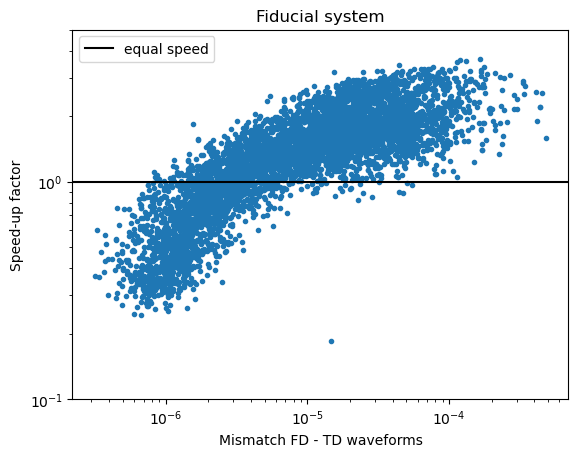

In [7]:
plt.figure()
plt.title('Fiducial system')
for ii in range(1):
    plt.loglog(mismatch_windowed_h[ii],speed_td[ii]/speed_fd[ii],'.')
    print(np.corrcoef(mismatch_windowed_h[ii],speed_td[ii]/speed_fd[ii])[0,1] )
plt.xlabel('Mismatch FD - TD waveforms')
plt.ylabel('Speed-up factor')
plt.axhline(1.0,label='equal speed',color='k')
plt.ylim([0.1, 5])
plt.legend()
plt.savefig('')

In [8]:
xfit, yfit = np.log10(mismatch_windowed_h[ii]),np.log10(speed_td[ii]/speed_fd[ii])
ind = np.argsort(xfit)
xfit = xfit[ind]
yfit = yfit[ind]
c = np.polynomial.polynomial.polyfit(xfit,yfit, 1, rcond=None, full=False)
xx = np.linspace( xfit.min(), xfit.max() )

0.5172269520769357


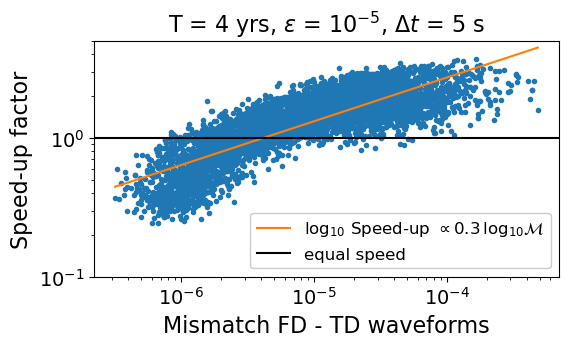

In [20]:
plt.figure(figsize=(figsize_std[0],figsize_std[1]))
plt.title(fr'T = {int(dt_T_eps[ii][1])} yrs, $\epsilon$ = ${as_si(dt_T_eps[ii][2],0)}$, $\Delta t$ = {int(dt_T_eps[ii][0])} s',fontsize=16)
for ii in range(1):
    plt.loglog(mismatch_windowed_h[ii],speed_td[ii]/speed_fd[ii],'.')
    print(np.corrcoef(mismatch_windowed_h[ii],speed_td[ii]/speed_fd[ii])[0,1] )
plt.plot(10**xx,10**(c[0] + c[1] * xx ) , label='$\log_{10}$ Speed-up $\propto 0.3 \, \log_{10} \mathcal {M}$')
plt.xlabel('Mismatch FD - TD waveforms',fontsize=16)
plt.ylabel('Speed-up factor',fontsize=16)
plt.axhline(1.0,label='equal speed',color='k')
plt.ylim([0.1, 5])
plt.legend(loc='lower right',framealpha=1.0, fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('figures/speedup_mismatch.pdf')

[-6.497710448863318, -6.838389602883775, -6.497813456427775, -6.741589354498262]


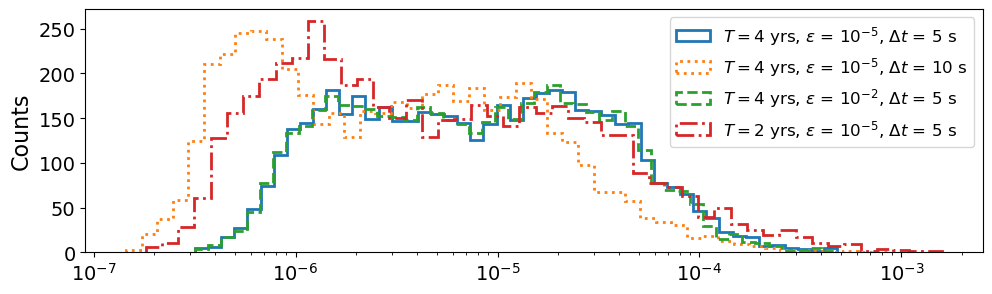

In [11]:
enlarge = 1.0
plt.figure(figsize=(figsize_std[0]*enlarge*2.0,figsize_std[1]*enlarge))
[plt.hist(speed,histtype='step', 
          bins=np.logspace(np.log10((speed).min()),np.log10((speed).max())), 
#         bins=np.logspace(-7,-2), 
          label=f'$T = {int(el[1])}$ yrs, $\epsilon$ = ${as_si(el[2],0)}$, $\Delta t$ = {int(el[0])} s',density=False,
          linewidth=2.0, linestyle=ls) 
         for speed,el,ls in zip(mismatch_windowed_h,dt_T_eps,linest)]
print([np.log10(speed.min())       for speed,el,ls in zip(mismatch_windowed_h,dt_T_eps,linest)])
# plt.xlabel('Mismatch FD - TD waveforms')
plt.ylabel('Counts',fontsize=16)
# plt.yticks([])
plt.legend(fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.semilogx()

# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,8))
# ax.set_aspect(figsize_std[0]*enlarge*1.75/(figsize_std[1]*enlarge))


plt.subplots_adjust(bottom=0.2) # or whatever
plt.savefig('figures/mismatch_different_systems_windowed_hann.pdf')


In [12]:
print("95 %",[np.quantile(speed,0.95) for speed,el in zip(mismatch_windowed_h,dt_T_eps)])
print("medians",[np.quantile(speed,0.5) for speed,el in zip(mismatch_windowed_h,dt_T_eps)])

for speed,pp in zip(mismatch_windowed_h,injection_pars):
    print(np.max(speed))
    print("worst par",pp[np.argmax(speed)][0], pp[np.argmax(speed)][1]/pp[np.argmax(speed)][0], pp[np.argmax(speed)][3], pp[np.argmax(speed)][4])
    

95 % [7.78422790154776e-05, 4.1386006036464615e-05, 7.433787577475483e-05, 9.743289071686985e-05]
medians [7.719051220544948e-06, 2.8893325352274957e-06, 7.585231295903494e-06, 4.087138271657853e-06]
0.0004816409249511766
worst par 9992906.141310893 1.131355551500033e-06 7.060600096664631 0.19801820863315006
0.0008723507617848236
worst par 110742.99558533158 1.0276193666573734e-06 11.504912867278867 0.6922233995838277
0.0004618427813817272
worst par 9992906.141310893 1.131355551500033e-06 7.060600096664631 0.19801820863315006
0.0015844408491736406
worst par 9725312.170038152 1.1723423181071835e-06 7.040119975952709 0.3005824824925789


In [13]:
for speed,pp,snr in zip(mismatch_windowed_h,injection_pars,SNR):
    print(np.max(speed * snr[:,2]))
    print("worst par",pp[np.argmax(speed * snr[:,2])][0], pp[np.argmax(speed * snr[:,2])][1]/pp[np.argmax(speed * snr[:,2])][0],
          pp[np.argmax(speed * snr[:,2])][3], pp[np.argmax(speed * snr[:,2])][4])


0.005060231280595914
worst par 3670041.7362535275 7.9579017824785e-05 13.709101864726545 0.5794130830706371
0.0027733470016856384
worst par 3670041.7362535275 7.9579017824785e-05 13.709101864726545 0.5794130830706371
0.004639490049006459
worst par 3670041.7362535275 7.9579017824785e-05 13.709101864726545 0.5794130830706371
0.008080697827686157
worst par 4730594.114158897 6.032268240752218e-06 8.273899574470173 0.5052184585979977


In [147]:
var=0
ii=0
for var in [0,1,3,4]:
    print(np.corrcoef([injection_pars[ii][:,var], mismatch_windowed_h[ii]])[0,1] )

0.7219149902412278
0.2318646969671873
-0.4285781232157949
-0.09774800379208937


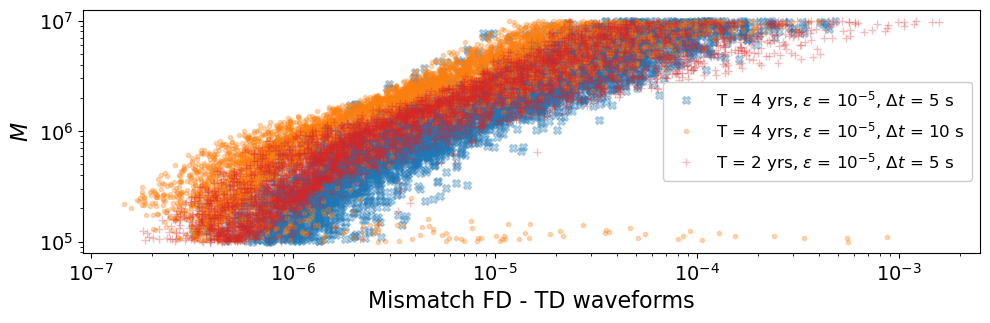

In [150]:
lab = ['$M$', '$\mu$', ' ','$p_0$','$e_0$', ]

var = 0
mark = ['X','.','o','+']
cmap = plt.cm.get_cmap('tab10')

enlarge = 1.0
plt.figure(figsize=(figsize_std[0]*enlarge*2.0,figsize_std[1]*enlarge))
[plt.loglog(mismatch_windowed_h[ii],injection_pars[ii][:,var],mark[ii],color=cmap(ii),
            label=f'T = {int(dt_T_eps[ii][1])} yrs, $\epsilon$ = ${as_si(dt_T_eps[ii][2],0)}$, $\Delta t$ = {int(dt_T_eps[ii][0])} s',alpha=0.3) for ii in [0,1,3]]
plt.xlabel('Mismatch FD - TD waveforms',fontsize=16)
plt.ylabel(lab[var],fontsize=16)
plt.legend(fontsize=12,framealpha=1.0)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplots_adjust(bottom=0.2) # or whatever

plt.savefig('figures/mismatch_mass_different_systems_windowed_hann.pdf')

(2.8284271247461903, 2.637717372816083)

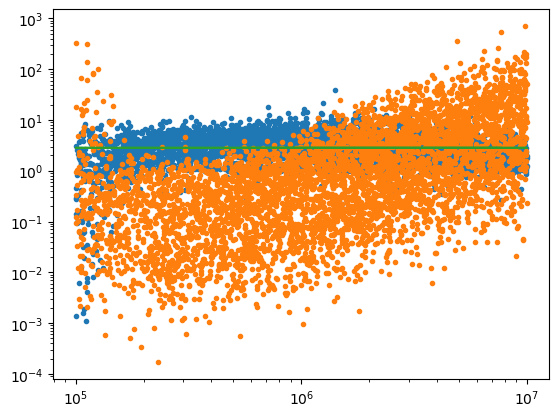

In [151]:
plt.loglog(injection_pars[0][:,var],(mismatch_windowed_h[0]/mismatch_windowed_h[1]),'.')
plt.loglog(injection_pars[0][:,var],(mismatch_windowed_h[1]/mismatch_windowed_h[3]),'.')
# plt.loglog(injection_pars[0][:,var],2*np.ones_like(injection_pars[0][:,var]),'-')

plt.loglog(injection_pars[0][:,var],2*np.sqrt(2)*np.ones_like(injection_pars[0][:,var]),'-')
2*np.sqrt(2),np.median((mismatch_windowed_h[0]/mismatch_windowed_h[1])[injection_pars[0][:,0]>3e5] )

[]

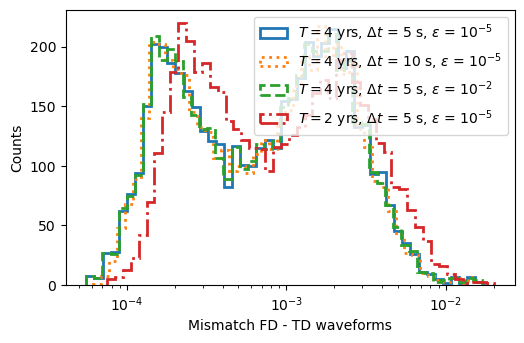

In [152]:

plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
[plt.hist(speed,histtype='step', 
          bins=np.logspace(np.log10((speed).min()),np.log10((speed).max())), 

          label=f'$T = {int(el[1])}$ yrs, $\Delta t$ = {int(el[0])} s, $\epsilon$ = ${as_si(el[2],0)}$',density=False,
          linewidth=2.0, linestyle=ls) 
         for speed,el,ls in zip(mismatch,dt_T_eps,linest)]

plt.xlabel('Mismatch FD - TD waveforms')
plt.ylabel('Counts')
# plt.yticks([])
plt.legend()
plt.semilogx()
# plt.tight_layout()
# plt.savefig('figures/mismatch_different_systems_nowindowed.pdf')

[]

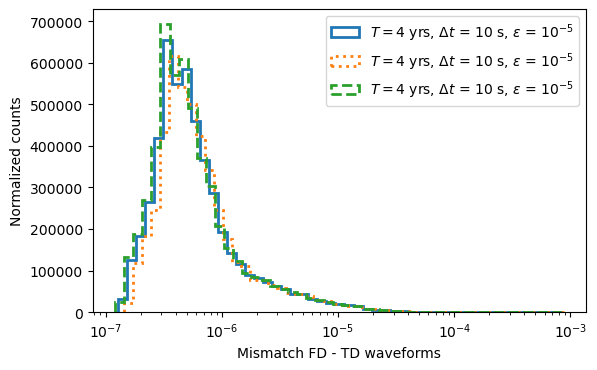

In [153]:
ii=1
enlarge = 1.1
plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
[plt.hist(speed,histtype='step', bins=np.logspace(np.log10((speed).min()),np.log10((speed).max())), 
          label=f'$T = {int(dt_T_eps[ii][1])}$ yrs, $\Delta t$ = {int(dt_T_eps[ii][0])} s, $\epsilon$ = ${as_si(dt_T_eps[ii][2],0)}$',density=True,
          linewidth=2.0, linestyle=ls) 
         for speed,ls in zip([mismatch_windowed_b[ii],mismatch_windowed_h[ii], mismatch_windowed_n[ii]],linest)]

plt.xlabel('Mismatch FD - TD waveforms')
plt.ylabel('Normalized counts')
# plt.yticks([])
plt.legend()
plt.semilogx()
# plt.ticklabel_format(axis='y', style='sci', scilimits=(0,8))
# plt.tight_layout()
# plt.savefig('figures/mismatch_different_systems_windowed_hann.pdf')



[]

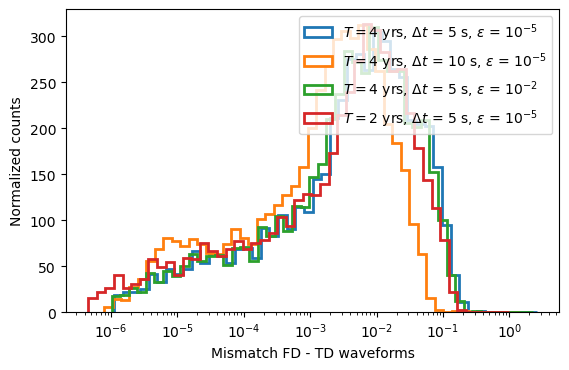

In [154]:
plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
[plt.hist(speed*snr[:,2]**2,histtype='step', bins=np.logspace(np.log10((speed*snr[:,0]**2).min()),np.log10((speed*snr[:,0]**2).max())), 
          label=f'$T = {int(el[1])}$ yrs, $\Delta t$ = {int(el[0])} s, $\epsilon$ = ${as_si(el[2],0)}$',density=False,
          linewidth=2.0, linestyle='-') 
         for speed,el,snr in zip(mismatch_windowed_h,dt_T_eps,SNR)]

plt.xlabel('Mismatch FD - TD waveforms')
plt.ylabel('Normalized counts')
plt.legend()
plt.semilogx()

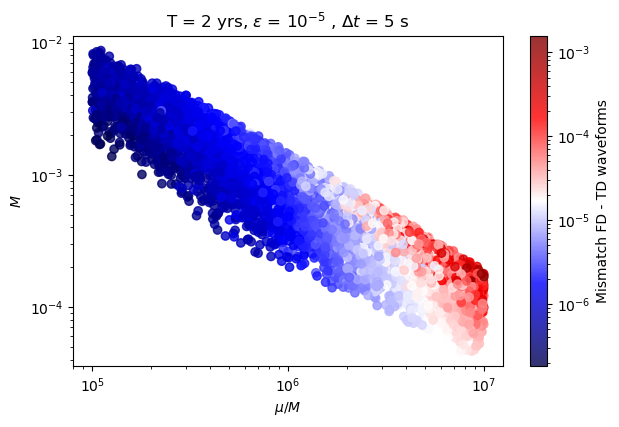

In [155]:
ii = 3
# Generate random data
x = injection_pars[ii][:,0]#injection_pars[ii][:,1]/injection_pars[ii][:,0]
omega = (injection_pars[ii][:,3]/(1-injection_pars[ii][:,4]**2))**(-3/2)/(2*np.pi*MTSUN_SI*injection_pars[ii][:,0])
y = omega#
z = mismatch_windowed_h[ii]#speed_td[ii]/speed_fd[ii]

# Define color scheme
cmap = plt.get_cmap('seismic')
colors = cmap(z)

enlarge = 1.2
# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
plt.title(f'T = {int(dt_T_eps[ii][1])} yrs, $\epsilon$ = ${as_si(dt_T_eps[ii][2],0)}$ , $\Delta t$ = {int(dt_T_eps[ii][0])} s')

plt.scatter(x, y, c=z, cmap=cmap, norm=matplotlib.colors.LogNorm(),alpha=0.8)
plt.colorbar(label='Mismatch FD - TD waveforms')
# plt.colorbar(label='log10 Mismatch')

# Set axis labels and title
ax.set_xlabel('$\mu/M$')
ax.set_ylabel('$M$')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_title('Speed up as a function of the parameter spac')

# Show the plot
# plt.tight_layout()
# plt.savefig('figures/mass_massratio_mismatch.pdf')

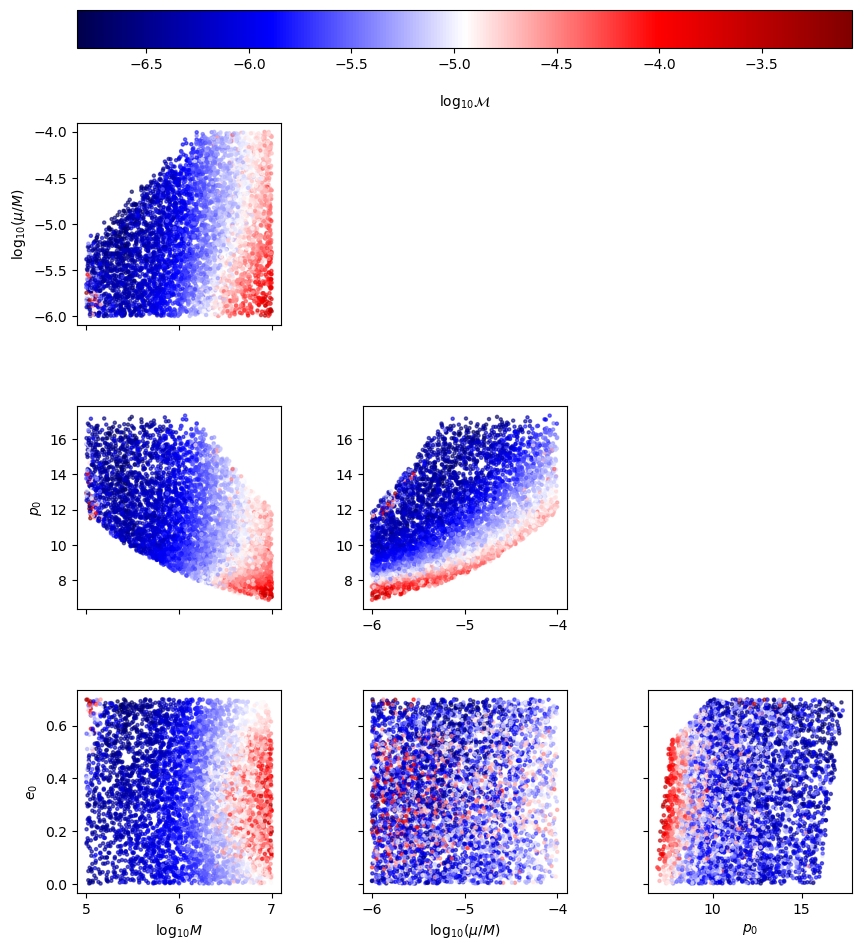

-6.838389602883775 -3.059308855345315


In [156]:
ii = 1
data_in = injection_pars[ii][:,[0,1,3,4]]
data_in[:,1] = np.log10(data_in[:,1]/data_in[:,0])
data_in[:,0] = np.log10(data_in[:,0])
get_colorplot(data_in, np.log10(mismatch_windowed_h[ii]),  ['$\log_{10}M$', '$\log_{10}(\mu/M)$','$p_0$','$e_0$'],'$\log_{10} \mathcal{M}$')
print(np.log10(mismatch_windowed_h[ii]).min(), np.log10(mismatch_windowed_h[ii]).max())

# ii = 3
# data_in = injection_pars[ii][:,[0,1,3,4]]
# data_in[:,1] = np.log10(data_in[:,1]/data_in[:,0])
# data_in[:,0] = np.log10(data_in[:,0])
# get_colorplot(data_in, np.log10(mismatch_windowed_h[ii]),  ['$\log_{10}M$', '$\log_{10}(\mu/M)$','$p_0$','$e_0$'],'$\log_{10} \mathcal{M}$')
# print(np.log10(mismatch_windowed_h[ii]).min(), np.log10(mismatch_windowed_h[ii]).max())


## Worst point in parameter space

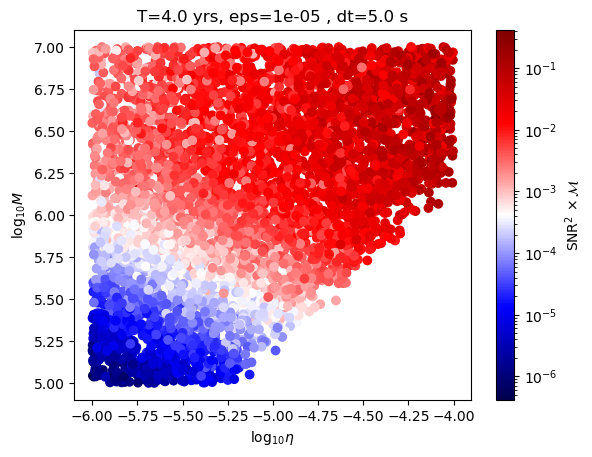

In [157]:
ii = 0
# Generate random data
x = np.log10(injection_pars[ii][:,1]/injection_pars[ii][:,0])
y = np.log10(injection_pars[ii][:,0])
z = SNR[ii][:,2]**2 * mismatch_windowed_h[ii]#mismatch_windowed_h[ii] # 

# Define color scheme
cmap = plt.get_cmap('seismic')
colors = cmap(z)

# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots()
plt.title(f'T={dt_T_eps[ii][1]} yrs, eps={dt_T_eps[ii][2]} , dt={dt_T_eps[ii][0]} s')
plt.scatter(x, y, c=z, cmap=cmap, norm=matplotlib.colors.LogNorm())
plt.colorbar(label=r'SNR$^2 \, \times \mathcal{M}$')

# Set axis labels and title
ax.set_xlabel('$\log_{10} \eta$')
ax.set_ylabel('$\log_{10} M$')
# ax.set_title('Speed up as a function of the parameter spac')

# Show the plot
# plt.tight_layout()
plt.show()

In [158]:
# worst Mismatch times SNR^2
ind = np.argsort(z)[-1:]
print("parameters ",[el for el in injection_pars[ii][ind][0][[0,1,3,4]] ])
print("snr = ",SNR[ii][ind,2],"mismatch", mismatch_windowed_h[ii][ind] )
# worst Mismatch 
z = mismatch_windowed_h[ii]
ind = np.argsort(z)[-1:]
print("parameters ",[el for el in injection_pars[ii][ind][0][[0,1,3,4]] ])
print("snr = ",SNR[ii][ind,2],"mismatch", mismatch_windowed_h[ii][ind] )

parameters  [3670041.7362535275, 292.0583167470244, 13.709101864726545, 0.5794130830706371]
snr =  [81.76166353] mismatch [6.18900235e-05]
parameters  [9992906.141310893, 11.305529838590854, 7.060600096664631, 0.19801820863315006]
snr =  [2.25763117] mismatch [0.00048164]


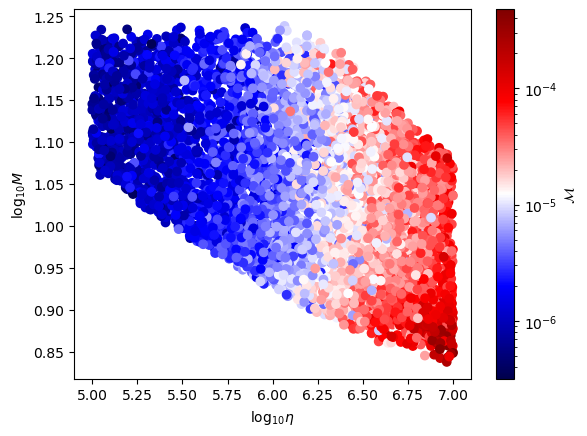

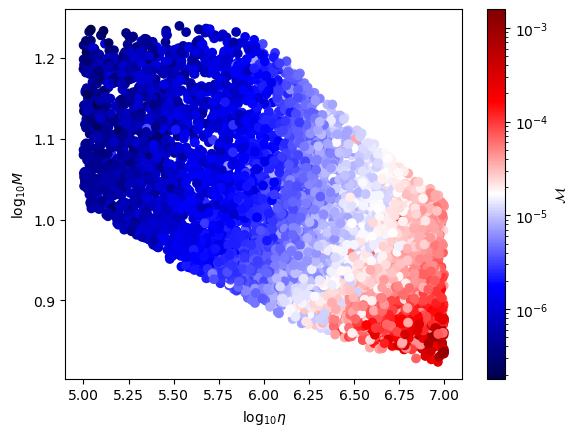

In [159]:
ii = 1
for ii in [0,3]:
    # Generate random data
#     x = np.log10(injection_pars[ii][:,1]/injection_pars[ii][:,0])
    x = np.log10(injection_pars[ii][:,0])
    y = np.log10(injection_pars[ii][:,3])
    z = mismatch_windowed_h[ii]#mismatch_windowed_h[ii] # 

    # Define color scheme
    cmap = plt.get_cmap('seismic')
    colors = cmap(z)

    # Plot scatter plot with colormap and color bar
    fig, ax = plt.subplots()
    # plt.title(f'SNR for T={dt_T_eps[ii][1]} yrs, eps={dt_T_eps[ii][2]} , dt={dt_T_eps[ii][0]} s')
    plt.scatter(x, y, c=z, cmap=cmap, norm=matplotlib.colors.LogNorm())
    plt.colorbar(label='$\mathcal{M}$')

    # Set axis labels and title
    ax.set_xlabel('$\log_{10} \eta$')
    ax.set_ylabel('$\log_{10} M$')
    # ax.set_title('Speed up as a function of the parameter spac')

    # Show the plot
    # plt.tight_layout()
    # plt.savefig('figures/mass_massratio_SNR.pdf')

# Speed analysis

In [186]:
var=0
ii=2
for var in [0,1,3,4]:
    print(np.corrcoef([injection_pars[ii][:,var], speed_td[ii]/speed_fd[ii]])[0,1] )

0.3731186944024771
0.21991936739308787
-0.3270543318593017
0.2403529349057511


median [1.3551724305260222, 1.0638856983731886, 0.8909406267921309, 1.2023531279084492]


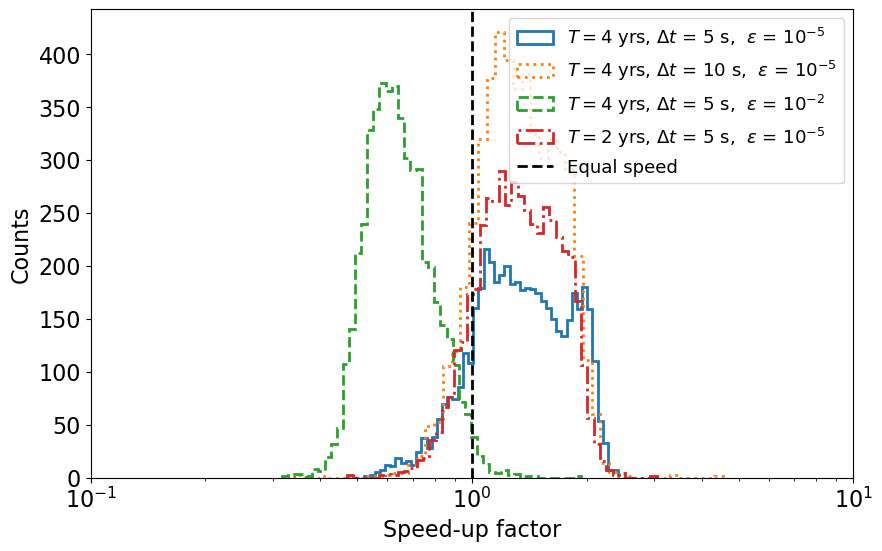

In [189]:
enlarge = 1.7
plt.figure(figsize=(figsize_std[0]*enlarge,figsize_std[1]*enlarge))
[plt.hist(sptd/spfd, bins=np.logspace(np.log10((sptd/spfd).min()),np.log10((sptd/spfd).max())),
          linewidth=2.0,linestyle=ls,
          histtype='step', label=f'$T = {int(el[1])}$ yrs, $\Delta t$ = {int(el[0])} s,  $\epsilon$ = ${as_si(el[2],0)}$',density=False)
 for spfd,sptd,el,ls in zip(speed_fd_downsampled,speed_td,dt_T_eps,linest)]

plt.axvline(1.0,color='k',label='Equal speed',linestyle='--',linewidth=2.0,)
plt.xlabel('Speed-up factor',fontsize=16)
plt.ylabel('Counts',fontsize=16)
plt.legend(loc='upper right',fontsize=13)
plt.semilogx()
plt.xlim([1e-1, 10])
plt.tick_params(axis='both', labelsize=16)

plt.savefig('figures/speed_different_systems_downsampled.pdf')

print("median",[np.quantile(sptd/spfd,0.5) for spfd,sptd,el in zip(speed_fd,speed_td,dt_T_eps)])

In [190]:
# open dataset
dset = h5py.File("results/emri_T2.0_seed2601996_dt10.0_eps0.01_fixedInsp1_tot_numb1000_CPU_newsens.h5",'r')
speed_td_cpu = dset['timing_td'][:500]
speed_fd_cpu = dset['timing_fd'][:500,0]
speed_fd_downsampled_cpu = dset['timing_fd'][:500,1]
dt_T_eps_cpu = [dset['dt'][...], dset['T'][...], dset['eps'][...] ]
dset.close()

median [1.3551724305260222, 1.0638856983731886, 0.8909406267921309, 1.2023531279084492]


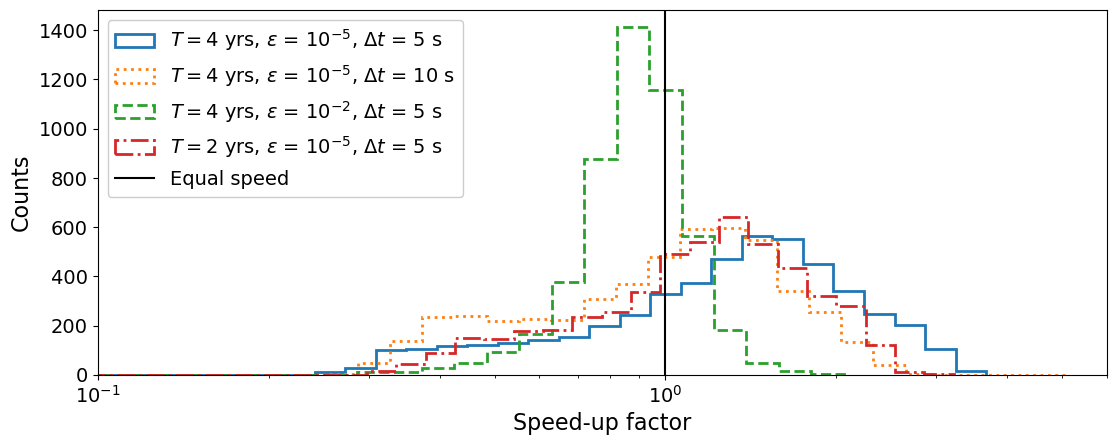

In [191]:
enlarge = 1.5
plt.figure(figsize=(figsize_std[0]*enlarge*1.5,figsize_std[1]*enlarge))
[plt.hist(sptd/spfd, 
          bins=np.logspace(np.log10((sptd/spfd).min()),np.log10((sptd/spfd).max())),
          linewidth=2.0,linestyle=ls,
          histtype='step', label=f'$T = {int(el[1])}$ yrs, $\epsilon$ = ${as_si(el[2],0)}$, $\Delta t$ = {int(el[0])} s',density=False)
 for spfd,sptd,el,ls in zip(speed_fd,speed_td,dt_T_eps,linest)]

# gpuratio = speed_td_cpu /speed_fd_cpu
# plt.hist(gpuratio, 
#   bins=np.logspace(np.log10((gpuratio).min()),np.log10((gpuratio).max()),num=20),
#   linewidth=2.0,linestyle=(0, (1, 1)),
#   histtype='step', weights=np.ones_like(gpuratio)*5000/500,
# label=f'$T = {int(dt_T_eps_cpu[1])}$ yrs, $\epsilon$ = ${as_si(dt_T_eps_cpu[2],0)}$, $\Delta t$ = {int(dt_T_eps_cpu[0])} s, CPU',density=False)
    


plt.axvline(x=1.0,ymin=0,ymax=1.76, color='k',label='Equal speed',linestyle='-',linewidth=1.5)
plt.xlabel('Speed-up factor',fontsize=16)
plt.ylabel('Counts',fontsize=16)
plt.legend(loc='upper left',fontsize=14,framealpha=1.0)
plt.semilogx()
plt.xlim([1e-1,6])
# plt.ylim([0, 2500])
plt.tick_params(axis='both', labelsize=14)
plt.subplots_adjust(bottom=0.2) # or whatever

# ax.set_aspect(figsize_std[0]*enlarge*1.75/(figsize_std[1]*enlarge))
# plt.tight_layout()
plt.savefig('figures/speed_different_systems.pdf',pad_inches=0.1)

print("median",[np.quantile(sptd/spfd,0.5) for spfd,sptd,el in zip(speed_fd,speed_td,dt_T_eps)])

[]

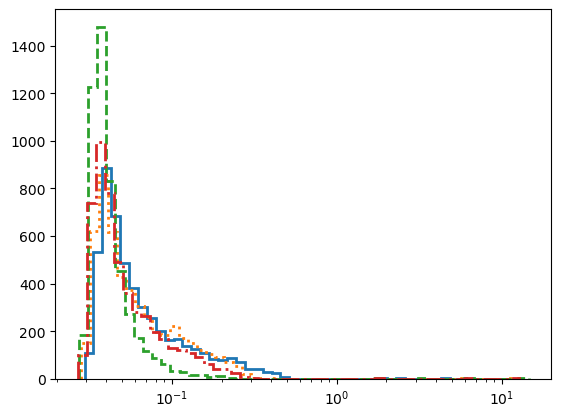

In [192]:
[plt.hist(spfd, 
          bins=np.logspace(np.log10((spfd).min()),np.log10((spfd).max())),
          linewidth=2.0,linestyle=ls,
          histtype='step', label=f'$T = {int(el[1])}$ yrs, $\Delta t$ = {int(el[0])} s,  $\epsilon$ = ${as_si(el[2],0)}$',density=False)
 for spfd,sptd,el,ls in zip(speed_fd,speed_td,dt_T_eps,linest)]
plt.semilogx()

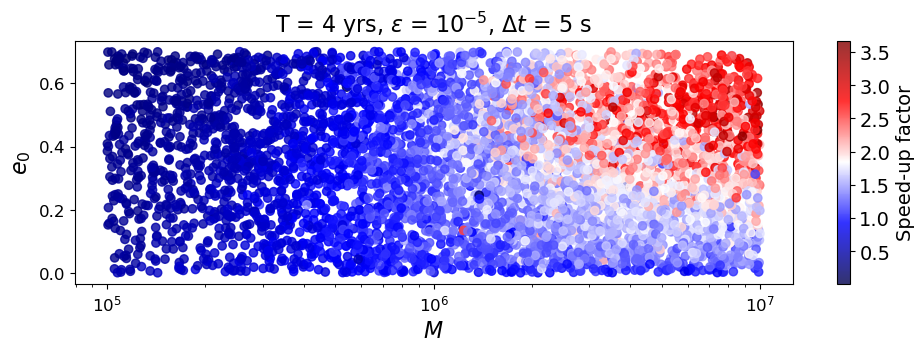

In [195]:
ii = 0
# Generate random data
x = injection_pars[ii][:,0]
y = injection_pars[ii][:,4]
z = speed_td[ii]/speed_fd[ii]

# Define color scheme
cmap = plt.get_cmap('seismic')
colors = cmap(z)

enlarge = 1.
# Plot scatter plot with colormap and color bar
fig, ax = plt.subplots(figsize=(figsize_std[0]*enlarge*2.0,figsize_std[1]*enlarge))
plt.title(fr'T = {int(dt_T_eps[ii][1])} yrs, $\epsilon$ = ${as_si(dt_T_eps[ii][2],0)}$, $\Delta t$ = {int(dt_T_eps[ii][0])} s',fontsize=16)

plt.scatter(x, y, c=z, cmap=cmap,alpha=0.8)
cbar = plt.colorbar(label='TD speed / FD speed')#,labelsize=16)
cbar.ax.set_ylabel('Speed-up factor', fontsize=14)

for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

# plt.colorbar(label='log10 Mismatch')

# Set axis labels and title
ax.set_xlabel('$M$',fontsize=16)
ax.set_ylabel('$e_0$',fontsize=16)
# ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_title('Speed up as a function of the parameter spac')
plt.tick_params(axis='both', labelsize=12)
plt.subplots_adjust(bottom=0.2) # or whatever
# Show the plot
# ax.set_aspect(figsize_std[0]*enlarge*1.75/(figsize_std[1]*enlarge))
# plt.tight_layout()
plt.savefig('figures/mass_ecc_speedup.pdf')


In [196]:
# get_colorplot(data_in, speed_td[ii]/speed_fd[ii],  ['$\log_{10}M$', '$\log_{10}(\mu/M)$','$p_0$','$e_0$'],'TD speed / FD speed')

[]

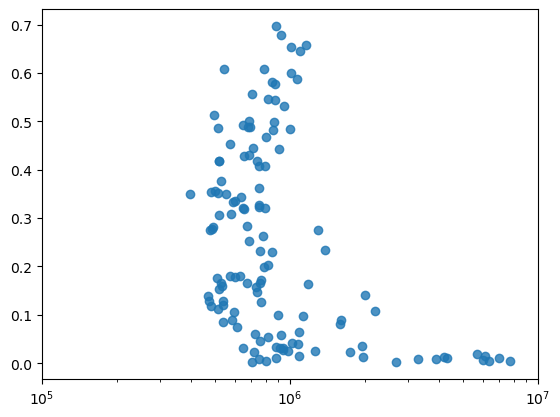

In [197]:
def find_regions(x, y, z, threshold):
    regions = []
    for i in range(len(x)):
        if (z[i] > threshold)and(z[i] < threshold*(1.05)):
            regions.append((x[i], y[i]))
    return regions

region = np.asarray(find_regions(x,y,z,1.0))

plt.figure()
plt.scatter(region[:,0], region[:,1],alpha=0.8)
plt.xlim([1e5,1e7])
plt.semilogx()

## Posterior comparison

In [5]:
from eryn.backends import HDFBackend
import h5py, glob

In [6]:
def get_autocorr_plot(to_check):
    n_dim  = to_check.shape[-1]
    plt.figure()
    for var in range(n_dim):
        y = to_check[:,:,var].T
        # Compute the estimators for a few different chain lengths
        N = np.exp(np.linspace(np.log(100), np.log(y.shape[1]), 10)).astype(int)
        gw2010 = np.empty(len(N))
        new = np.empty(len(N))
        for i, n in enumerate(N):
            gw2010[i] = autocorr_gw2010(y[:, :n])
            new[i] = autocorr_new(y[:, :n])

        # Plot the comparisons
        # plt.loglog(N, gw2010, "o-", label="G&W 2010")
        plt.loglog(N, new, "o-", label=f"new var{var}")

    plt.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    # plt.axhline(true_tau, color="k", label="truth", zorder=-100)
    plt.xlabel("number of samples, $N$")
    plt.ylabel(r"$\tau$ estimates")
    plt.legend(fontsize=14);
    plt.show()



In [7]:
datasets = glob.glob('results/final_CPU_MCMC_emri_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt1_downsample1_injectFD1_templatefd_final.h5_skip94')
datasets
# samp.shape

['results/final_CPU_MCMC_emri_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt1_downsample1_injectFD1_templatefd_final.h5_skip94']

results/final_CPU_MCMC_emri_M3.7e+06_mu2.9e+02_p1.4e+01_e0.58_T4.0_eps0.01_seed2601996_nw32_nt1_downsample1_injectFD1_templatefd_final.h5_skip94
{'StretchMove_0': {'acceptance_fraction': array([[0.2729206 , 0.26748582, 0.27150284, 0.27410208, 0.2731569 ,
        0.26665879, 0.28249055, 0.27185728, 0.27221172, 0.26358696,
        0.26854915, 0.25756144, 0.27611059, 0.27280246, 0.27504726,
        0.26524102, 0.26736767, 0.28296314, 0.26571361, 0.27752836,
        0.27020321, 0.26949433, 0.27055766, 0.26004253, 0.26086957,
        0.27374764, 0.27327505, 0.2709121 , 0.27103025, 0.26701323,
        0.26405955, 0.26784026]])}}


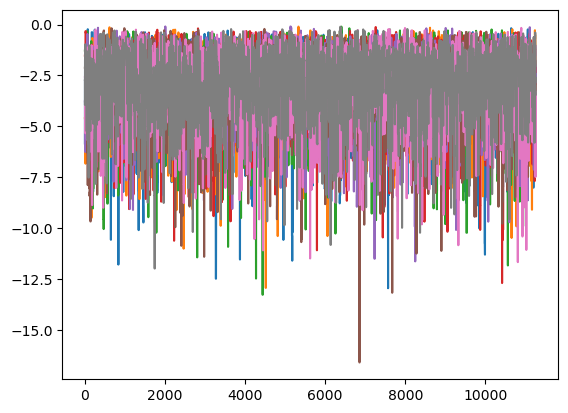

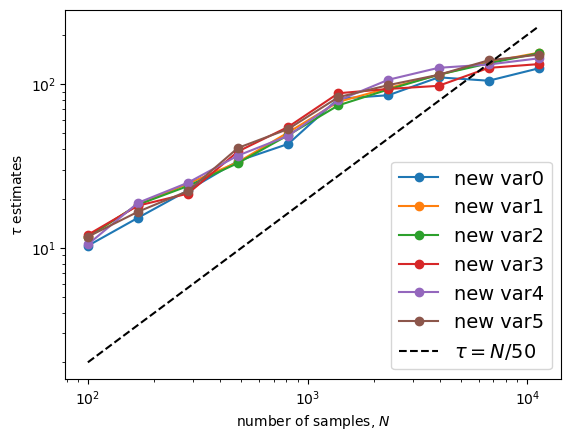

In [8]:
# filename = 'emri_M1e+06_mu1e+01_p9.5_e0.35_T1.0_eps1e-05_seed2601996_injectFD1_templatefd.h5'
temp=0

samp_final = []
for filename in datasets:
    file  = HDFBackend(filename)
    print(filename)
    print(file.get_move_info())
    max_iter = file.iteration
    burn = int(max_iter*0.1)
    thin = 1
    ll = file.get_log_like(discard=burn, thin=thin)
    mask = np.arange(8)#[file.get_move_info()['StretchMove_0']['acceptance_fraction'][0]>0.1]
    plt.figure()
    [plt.plot(ll[:,temp,walker],'-',label=f'{walker}') for walker in mask]
    plt.show()
    
    # get samples
    samp = file.get_chain(discard=burn, thin=thin)['emri'][:,temp,mask,...]
    get_autocorr_plot(samp[:,:,0,:])
    logl = ll[:,temp,mask,...]

    inds = file.get_inds(discard=burn, thin=thin)['emri']
    samp_final.append( np.hstack((samp[inds[:,temp,mask,...]],logl[inds[:,temp,mask,0],None])) )

In [9]:
# samp_final[0]
# np.asarray([np.append(el[0],el[1]) for el in samp_final])

In [10]:
M,mu,p0,e0 = 3670041.7362535275, 292.0583167470244, 13.709101864726545, 0.5794130830706371
Phi_phi0 = np.pi/3
Phi_r0 = np.pi/3

truths = [
            np.log(M),  
            np.log(mu/M),
            p0,
            e0,
            Phi_phi0, 
            Phi_r0,
                0.0
        ]

CORNER_KWARGS = dict(
#     smooth=0.6,
    labels=[r'$\log M$', r'$\log (\mu / M)$', r'$p_0$', r'$e_0$', 
#             r'$D_L$',
#             r'$\cos{\theta_K}$', r'$\phi_K$',
#            r'$\cos{\theta_S}$', r'$\phi_S$',
           r'$\Phi_{\phi 0}$', r'$\Phi_{r 0}$','Log-Likelihood'
           ],
    bins=40,
    truths = truths,
    label_kwargs=dict(fontsize=13),
    title_kwargs=dict(fontsize=13),
#     quantiles=[0.16, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    plot_density=False,
    plot_datapoints=False,
    fill_contours=False,
    show_titles=False,
    max_n_ticks=7,
    truth_color='k'
)
import matplotlib.lines as mlines

def get_normalisation_weight(len_current_samples, len_of_longest_samples):
    return np.ones(len_current_samples) * (len_of_longest_samples / len_current_samples)


def overlaid_corner(samples_list, sample_labels, name_save=None, corn_kw=CORNER_KWARGS):
    """Plots multiple corners on top of each other"""
    # get some constants
    n = len(samples_list)
    _, ndim = samples_list[0].shape
    max_len = max([len(s) for s in samples_list])
    cmap = plt.cm.get_cmap('Set1',)
    colors = [cmap(i) for i in range(n)]#['black','red', 'royalblue']#

    plot_range = []
    for dim in range(ndim):
        plot_range.append(
            [
                min([min(samples_list[i].T[dim]) for i in range(n)]),
                max([max(samples_list[i].T[dim]) for i in range(n)]),
            ]
        )

    CORNER_KWARGS.update(range=plot_range)
    fig = corner.corner(
        samples_list[0],
        color=colors[0],
        weights=get_normalisation_weight(len(samples_list[0]), max_len),
        **CORNER_KWARGS
    )

    for idx in range(1, n):
        fig = corner.corner(
            samples_list[idx],
            fig=fig,
            weights=get_normalisation_weight(len(samples_list[idx]), max_len),
            color=colors[idx],
            **CORNER_KWARGS
        )

    plt.legend(
        handles=[
            mlines.Line2D([], [], color=colors[i], label=sample_labels[i])
            for i in range(n)
        ],
        fontsize=25, frameon=False,
        bbox_to_anchor=(1, ndim), loc="upper right"
    )
#     fig.subplots_adjust(right=1.0,top=1.0)

    plt.subplots_adjust(left=-0.1, bottom=-0.1, right=None, top=None, wspace=None, hspace=0.15)

    if name_save is not None:
        plt.savefig(name_save+".pdf", pad_inches=0.2, bbox_inches='tight')
    else:
        plt.show()


In [11]:
# plt.savefig?

In [12]:
name_mcmc = [el.split('downsample1_')[-1].split('.h5')[0] for el in datasets]
name_mcmc

['injectFD1_templatefd_final']

In [13]:
samp_final[0].shape

(90088, 7)

In [14]:
name_mcmc

['injectFD1_templatefd_final']

In [15]:
name_mcmc = ['TD injection, FD template',
#             'TD injection, TD template',
#              'FD injection, FD template',
            ]

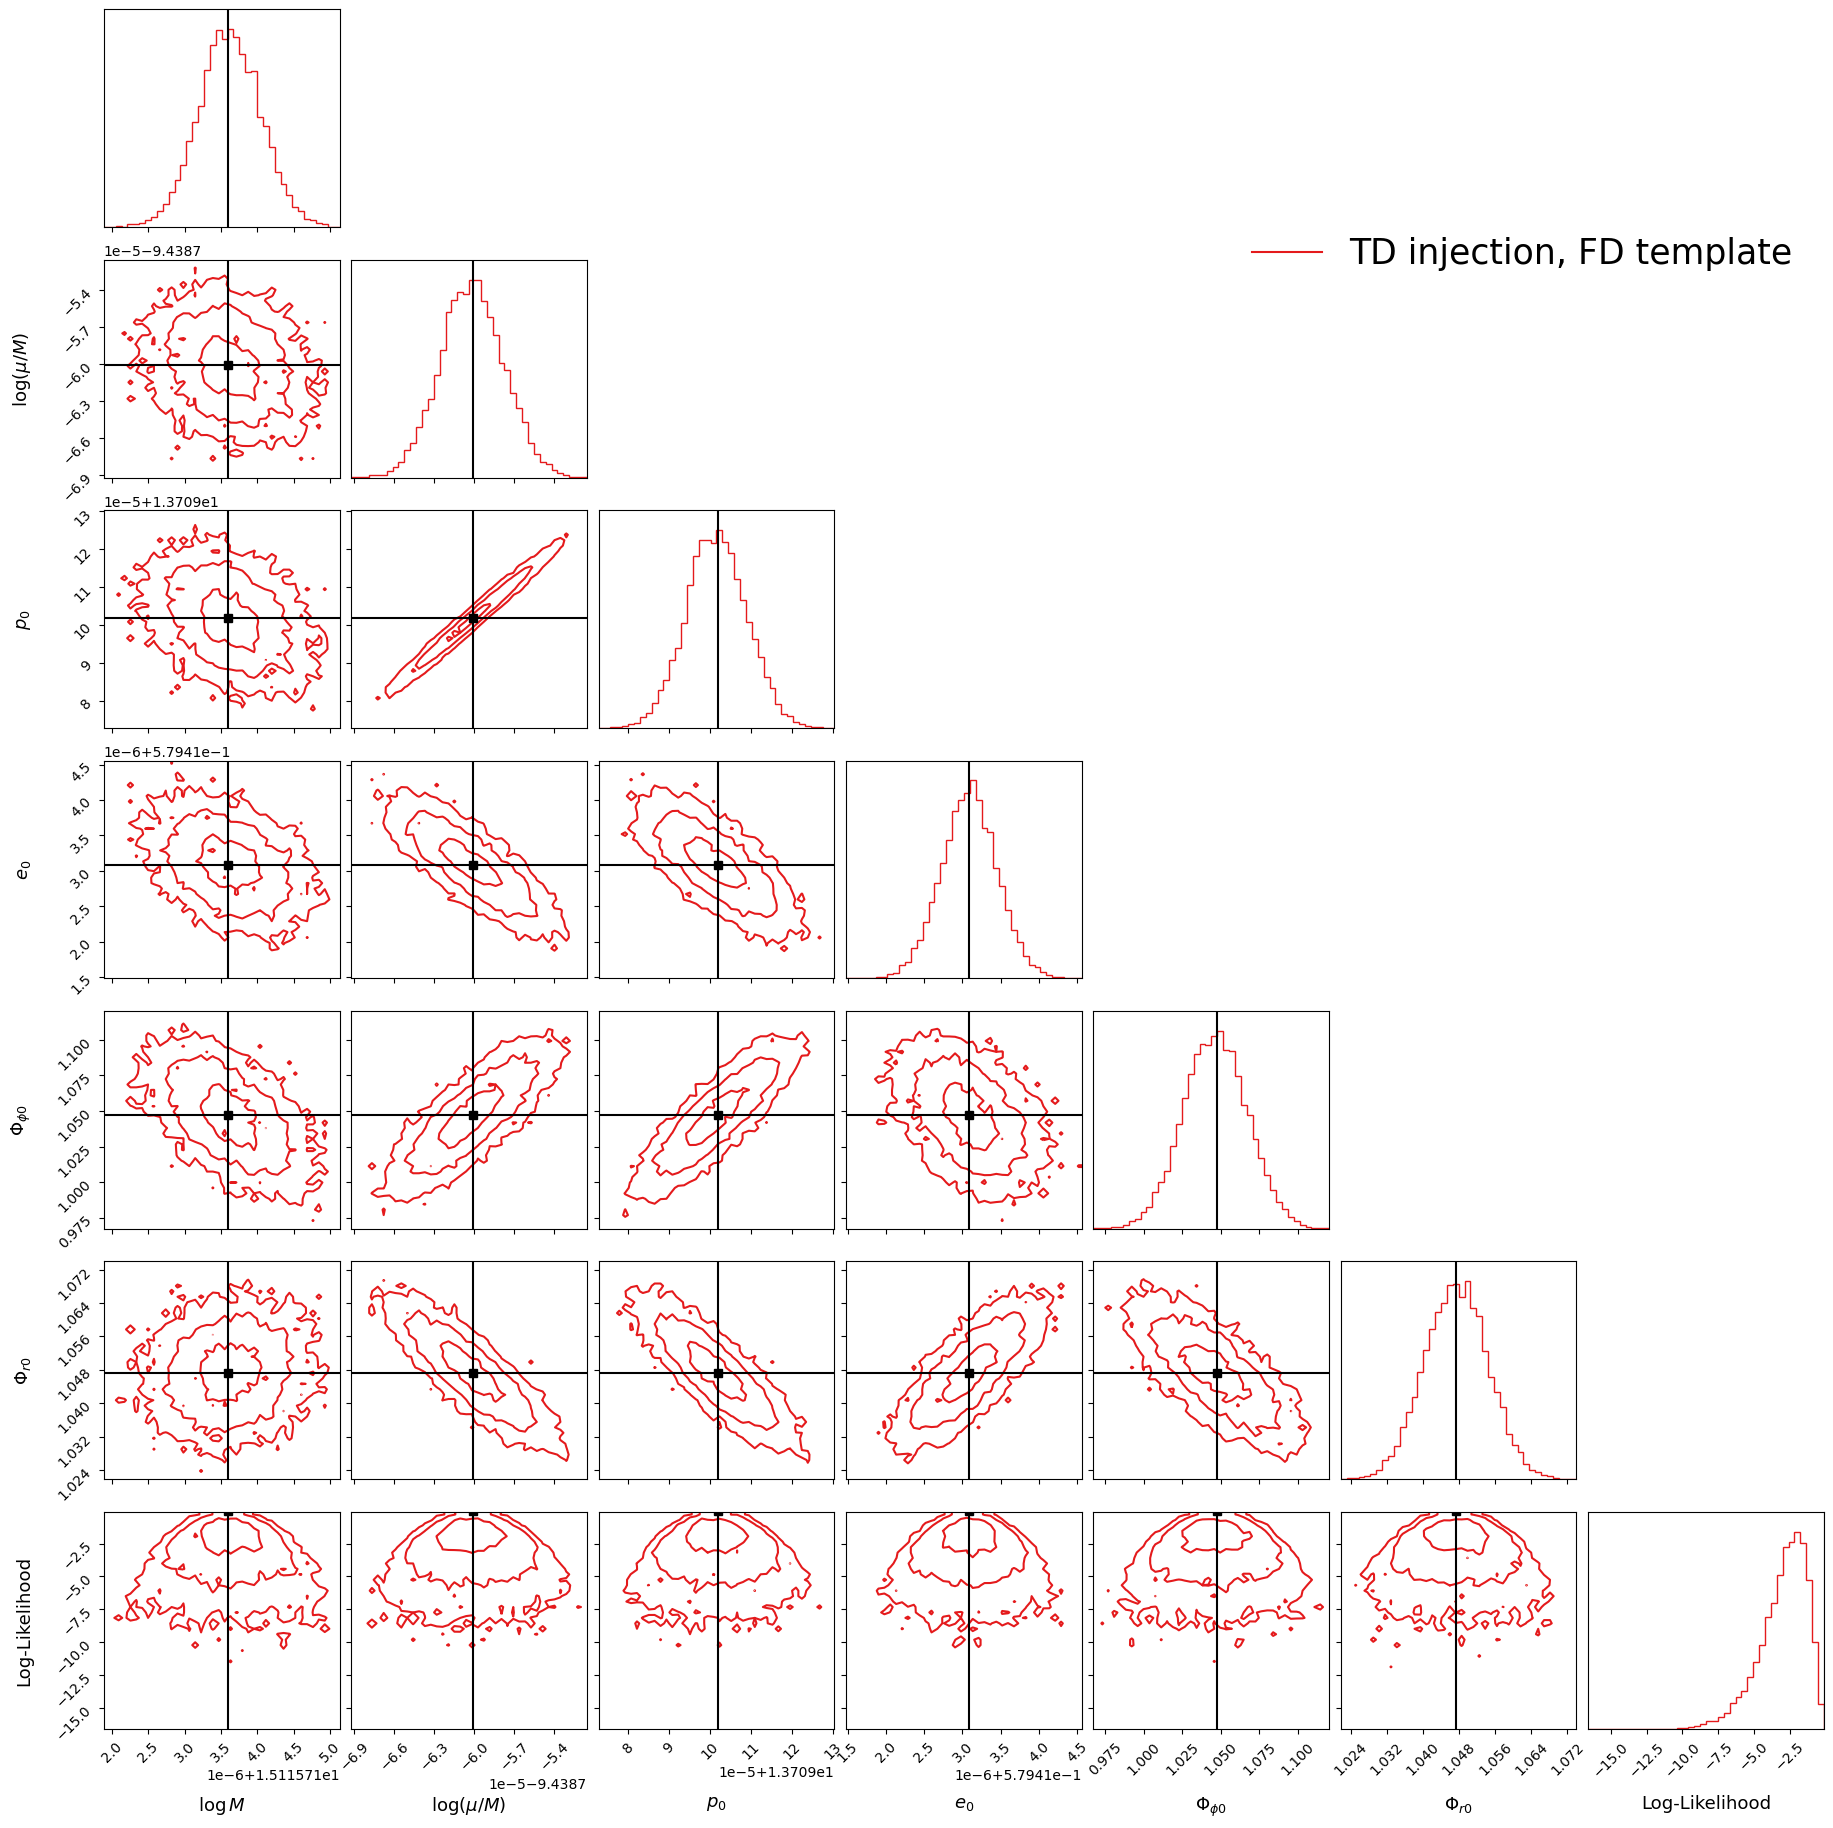

In [16]:
overlaid_corner(samp_final, name_mcmc)#, name_save='figures/posterior_comparison_intrinsic')

In [18]:
samp_final[0].shape

(90088, 7)

In [17]:
np.save("samples_CPU",samp_final[0][-5000:])

In [59]:
# np.save("covariance.npy",samp_final[0][:,:-1])